## Import necessary modules, set up environment

In [2]:

from matplotlib import pyplot as plt
from gymnasium import spaces
%matplotlib inline
# import gymnasium as gym
# from gym.envs.registration import registry, register
from minigrid.wrappers import DictObservationSpaceWrapper # so that text mission string is actually a numerical dict

# env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode = "rgb_array")
# env = DictObservationSpaceWrapper(env) # ONLY DO THIS FOR PPO TRAINING
# env.metadata['render_modes'] = ["rgb_array"]
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch import nn
# import gym
import torch



/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [66]:
obs, info = env.reset()
print(obs['mission'])

AttributeError: 'list' object has no attribute 'shape'

In [82]:
def no_zeros(l):
    out = []
    for elt in l:
        if elt != 0:
            out.append(elt)
        else:
            return out

In [118]:

env = gymnasium.make("MiniGrid-Empty-16x16-v0", render_mode="rgb_array")
ob1, info = env.reset()
env = DictObservationSpaceWrapper(env)
ob2, info = env.reset()



print(ob1['mission'])
print(no_zeros(ob2['mission']))

for i in range(100):

    action = env.action_space.sample()

    ob3, reward, term, truc, info = env.step(action)
    print(no_zeros(ob3['mission']))
    print(reward)


get to the green goal square
[20, 38, 31, 2, 15, 35]
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31, 2, 15, 35]
0
[20, 38, 31

In [55]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

In [190]:
class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Dict, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        direction = observation_space['direction']
        image = observation_space['image']
        mission_string = observation_space['mission']
        n_input_channels = image.shape[0] # should be 3, for RGB
        
        
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        direction_output_dim = 8
        self.direction_net = nn.Sequential(nn.Linear(direction.n, direction_output_dim), nn.ReLU()) 
        
        
        ## add text extractor
        self.transformer = nn.Transformer(d_model=len(mission_string), nhead=2, num_encoder_layers=2, num_decoder_layers=2) # squared because of one hot encoding
        

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space['image'].sample()[None]).float()).shape[1] ## 1024 for this example
            
        self.sentence_transformer_dim = len(mission_string) # is one-hot best here? or should we condense it to 50D vector?
            
        linear_input_dim = n_flatten + self.sentence_transformer_dim + direction_output_dim
        self.linear = nn.Sequential(nn.Linear(linear_input_dim, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        image_features = self.cnn(observations['image']) # .transpose((2, 0, 1)
        direction_features = self.direction_net(observations['direction'])
        if direction_features.shape[1] == 1:
            direction_features = direction_features.squeeze(1)
            
       
        one_hot_mission = observations['mission'].squeeze(0)
        mission_string_encoding = torch.empty((observations['mission'].shape[0], self.sentence_transformer_dim))
        
        # turn back into labels instead of one hot encoding
        for i in range(0, self.sentence_transformer_dim**2, self.sentence_transformer_dim):

            if len(one_hot_mission.size()) == 1:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = (torch.argmax(one_hot_mission[i:i+self.sentence_transformer_dim], dim = 0))
            else:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = torch.argmax(one_hot_mission[:, i:i+self.sentence_transformer_dim], dim = 1)
       
        src = trg = torch.as_tensor(mission_string_encoding).unsqueeze(0).float()
        
        sentence_features = self.transformer(src, trg).squeeze(0) # to match dimensions

        
        try:
            observations = torch.cat([image_features, sentence_features, direction_features], dim = 1)
        except Exception as err:
            print(err)
            print("image features dim", image_features.shape)
            print("sentence features dim", sentence_features.shape)
            print("direction features dim", direction_features.shape)
        return self.linear(observations)

In [191]:
import minigrid
from minigrid.wrappers import ImgObsWrapper
from stable_baselines3 import PPO
import gymnasium

policy_kwargs = dict(
    features_extractor_class=MinigridFeaturesExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

env = gymnasium.make("MiniGrid-Empty-16x16-v0", render_mode="rgb_array")
env = DictObservationSpaceWrapper(env)
env.metadata['render_modes'] = ["rgb_array"]

model = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(2e5)
## the problem: ppo requires a gym env to train. but the env observation space is of type gymnasium.spaces. 

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.02e+03 |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 415      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 990         |
|    ep_rew_mean          | 0.0549      |
| time/                   |             |
|    fps                  | 224         |
|    iterations           | 2           |
|    time_elapsed         | 18          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009920765 |
|    clip_fraction        | 0.0529      |
|    clip_range      

In [192]:
model.save("minigrid_models/minigrid-ppo/1")

/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'minigrid_models/minigrid-ppo' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [205]:
from utils import record_videos, show_videos

model = PPO.load("minigrid_models/minigrid-ppo/1")

env = gymnasium.make("MiniGrid-Empty-16x16-v0", render_mode="rgb_array")
env = DictObservationSpaceWrapper(env)
env = gymnasium.wrappers.RecordVideo(env, 'video', episode_trigger=lambda e: True)
obs, info = env.reset()
done = False
while not done:
    action = model.predict(obs)[0]
    obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4



/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


TypeError: must be real number, not NoneType

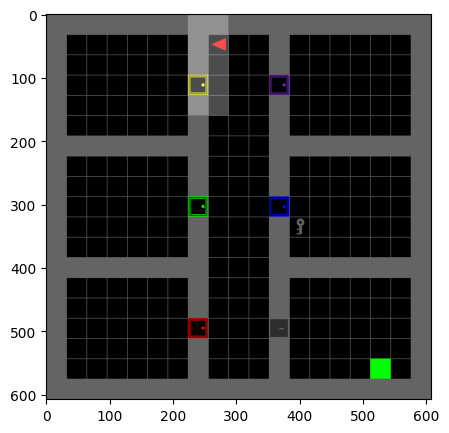

In [5]:
render = env.render()
fig, ax = plt.subplots(ncols=1, figsize=(12, 5))
ax.imshow(render) # , cmap=plt.get_cmap('gray')
plt.show()

In [9]:
obs

{'image': array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0],
         [1, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [4, 4, 1],
         [1, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0],
         [1, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0],
         [1, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [2, 5, 0],
         [2, 5, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         [0, 

In [18]:
env.action_space.sample()

3